In [1]:
!pip install numpy numpy-stl matplotlib Pillow gudhi

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from stl import mesh
from PIL import Image
import io

import gudhi

In [2]:
stl_file = 'data/stretching-cat.stl'

In [3]:
# The example represents a skull of a domestic cat.

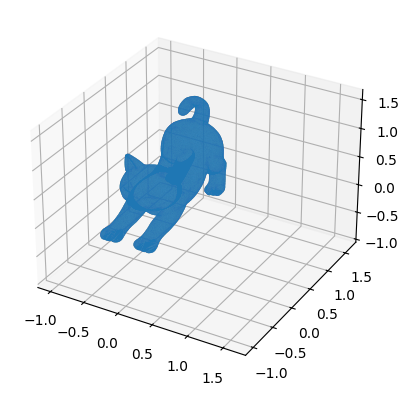

In [4]:
figure = plt.figure()
axes = figure.add_subplot(projection='3d')
your_mesh = mesh.Mesh.from_file(stl_file)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.show()

In [5]:
plt.close()
del figure

In [6]:
# for better view go to https://www.viewstl.com/

In [7]:
def images_from_stl(stl_file, num_views):

    your_mesh = mesh.Mesh.from_file(stl_file)
    print("STL file loaded.")
    image_list = []

    def rotation_matrix(angle):
        rad = np.radians(angle)
        cos_a = np.cos(rad)
        sin_a = np.sin(rad)
        return np.array([[cos_a, -sin_a, 0],
                         [sin_a,  cos_a, 0],
                         [0,      0,     1]])

    for i in range(num_views):
        angle = 360 / num_views * i
        print(f"Generating image {i+1}/{num_views}, rotated by {angle} degrees.", end="\r")
        rot_matrix = rotation_matrix(angle)

        rotated_vectors = np.dot(your_mesh.vectors, rot_matrix)
        fig, ax = plt.subplots(figsize=(6, 6))
        x = rotated_vectors[:, :, 0].flatten()
        z = rotated_vectors[:, :, 2].flatten()
        ax.scatter(x, z, c='blue', s=1, alpha=0.6)
        ax.set_aspect('equal')
        ax.axis('off')
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        image = Image.open(buf)
        image_list.append(image)
        plt.close(fig)

    print(f"\nGenerated {len(image_list)} rotated 2D projections from STL file.")
    return image_list

In [8]:
images = images_from_stl(stl_file, num_views=30)

STL file loaded.
Generating image 30/30, rotated by 348.0 degrees.
Generated 30 rotated 2D projections from STL file.


In [11]:

# we convert image to grayscale, flatten the 2D pixels and convert to float due to gudhi requirements
def image_to_point(image):
    image = image.convert("L")
    array = np.array(image).flatten()
    array = [float(x) for x in array]

    return array

In [12]:
points = [image_to_point(image) for image in images]
del images #we want to spare memory


In [15]:
def rips_persistence(points, max_dimension=2):
    rips_complex = gudhi.RipsComplex(points=points)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
    print(result_str)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    pers_homology = simplex_tree.persistence()
    return pers_homology

Rips complex is of dimension 2 - 4525 simplices - 30 vertices.


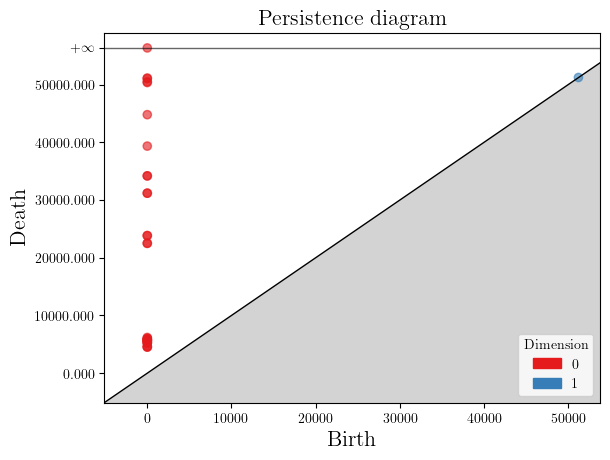

In [16]:
pers_homology=rips_persistence(points=points)
gudhi.plot_persistence_diagram(pers_homology)
plt.show()